In [1]:
#Necessary imports for this code to run smoothly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle

In [2]:
#Inputting all saved models for making campaign level predictions
model1 = pickle.load(open('lin_model_no_capacitors_removed.pkl', 'rb'))
scaler_input1 = pickle.load(open('scaler_input_no_capacitors_removed.pkl', 'rb'))
scaler_output1 = pickle.load(open('scaler_output_no_capacitors_removed.pkl', 'rb'))

model2 = pickle.load(open('lin_model_capacitors_removed.pkl', 'rb'))
scaler_input2 = pickle.load(open('scaler_input_capacitors_removed.pkl', 'rb'))
scaler_output2 = pickle.load(open('scaler_output_capacitors_removed.pkl', 'rb'))

In [53]:
#Reading the data
df = pd.read_csv('Amreli NRM data for model building final.csv')
campaign = np.unique(df['campaign'])

#Removing first heat from the analysis because previous induction furnace parameters are inputs for this model
for c in campaign:
    dfc = df[df['campaign']==c]
    i = dfc.index[0]
    df = df.drop(i)
    
df = df.reset_index(drop=True)

#Missing values for capacitors replaced with 0
df['Number of capacitors removed'].fillna(0, inplace=True)

#Threshold for total heat time
threshold = 150

for i in range(df.shape[0]):
    if(df.loc[i,'Total Heat Time previous (minutes)']>threshold):
        df.loc[i,'Total Heat Time previous (minutes)']= threshold
    if(df.loc[i,'Total Heat Time (minutes)']>threshold):
        df.loc[i,'Total Heat Time (minutes)']= threshold
        
#Units conversion
df['Input energy previous (KWH)'] = df['Power previous']*df['Total Heat Time previous (minutes)']/60
df['Input energy (KWH)'] = df['Power']*df['Total Heat Time (minutes)']/60

#Selecting campaign for which we want to make predictions
df1 = df[df['campaign']==8]

In [54]:
#Code for making predictions
input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Previous Voltage','Previous Frequency','Refractory lining before heating','Number of capacitors removed','Tapping Temperature (C)']
output_columns = ['Voltage','Frequency','Refractory lining after heating']
X = df1[input_columns].values
y = df1[output_columns].values
Store_Result = {}
k = 0
for i in range(df1.shape[0]):
    if X[i,7] == 0:
        model = model1
        scaler_input = scaler_input1
        scaler_output = scaler_output1
    else:
        model = model2
        scaler_input = scaler_input2
        scaler_output = scaler_output2
        
    if(i==0):
        X_s = scaler_input.transform(X[i,:].reshape(1,len(X[i,:])))
        y_s = scaler_output.transform(y)
        y_p = model.predict(X_s)
        y_pred = scaler_output.inverse_transform(y_p)
        dic = {}
        dic['Pred Voltage'] = y_pred[0][0]
        dic['Pred Frequency'] = y_pred[0][1]
        dic['Pred Refractory'] = y_pred[0][2]
        dic['Actual Voltage'] = y[i,0]
        dic['Actual Frequency'] = y[i,1]
        dic['Actual Refractory'] = y[i,2]
        Store_Result[k] = dic
        k = k+1
    else:
        X[i,4] = Store_Result[k-1]['Pred Voltage']
        X[i,5] = Store_Result[k-1]['Pred Frequency']
        X[i,6] = Store_Result[k-1]['Pred Refractory']

        X_s = scaler_input.transform(X[i,:].reshape(1,len(X[i,:])))
        y_s = scaler_output.transform(y)
        
        y_p = model.predict(X_s)
        y_pred = scaler_output.inverse_transform(y_p)
        dic = {}
        dic['Pred Voltage'] = y_pred[0][0]
        dic['Pred Frequency'] = y_pred[0][1]
        dic['Pred Refractory'] = y_pred[0][2]
        dic['Actual Voltage'] = y[i,0]
        dic['Actual Frequency'] = y[i,1]
        dic['Actual Refractory'] = y[i,2]
        
        Store_Result[k] = dic
        k = k+1

In [55]:
Pred = np.zeros((df1.shape[0],3))
Act = np.zeros((df1.shape[0],3))

for i in range(df1.shape[0]):
    Pred[i,0] = Store_Result[i]['Pred Voltage']
    Pred[i,1] = Store_Result[i]['Pred Frequency']
    Pred[i,2] = Store_Result[i]['Pred Refractory']
    
    Act[i,0] = Store_Result[i]['Actual Voltage']
    Act[i,1] = Store_Result[i]['Actual Frequency']
    Act[i,2] = Store_Result[i]['Actual Refractory']

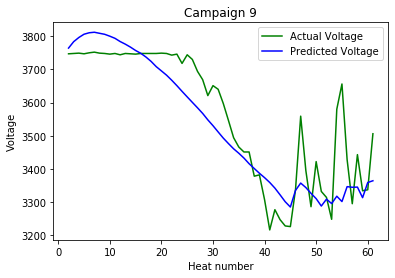

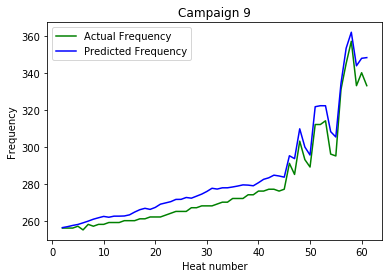

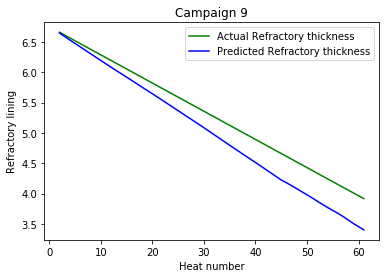

In [56]:
#Plots
end = df1.shape[0]+2 # for campaign 9
# end = 62 # for campaign 8
plt.plot(range(2,end),Act[:,0],c='g');
plt.plot(range(2,end),Pred[:,0],c='b');
plt.xlabel('Heat number')
plt.ylabel('Voltage')
plt.title('Campaign 9')
plt.legend(['Actual Voltage','Predicted Voltage'])
plt.show()
plt.plot(range(2,end),Act[:,1],c='g');
plt.plot(range(2,end),Pred[:,1],c='b');
plt.xlabel('Heat number')
plt.ylabel('Frequency')
plt.legend(['Actual Frequency','Predicted Frequency'])
plt.title('Campaign 9')
plt.show()
plt.plot(range(2,end),Act[:,2],c='g');
plt.plot(range(2,end),Pred[:,2],c='b');
plt.xlabel('Heat number')
plt.ylabel('Refractory lining')
plt.legend(['Actual Refractory thickness','Predicted Refractory thickness'])
plt.title('Campaign 9')
plt.show()

In [57]:
#Metrics
for i in range(3):
    print(output_columns[i])
    print("MSE score is {}".format(mean_squared_error(Act[:,i], Pred[:,i])))
    print("R2 score is {}".format(r2_score(Act[:,i], Pred[:,i])))
    print("NMSE score is {}".format(np.sum(np.square(Act[:,i]- Pred[:,i]))/np.sum(np.square(Act[:,i]-np.mean(Act[:,i])))*100))

Voltage
MSE score is 8519.48927301919
R2 score is 0.76667820857012
NMSE score is 23.332179142987997
Frequency
MSE score is 44.251852788649096
R2 score is 0.9303781622793328
NMSE score is 6.9621837720667195
Refractory lining after heating
MSE score is 0.10429017232674478
R2 score is 0.838821461007857
NMSE score is 16.1178538992143
